In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import os
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [5]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [6]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

## ResNet 18

In [55]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)
        
        # Adjusting the input size for the fully connected layer
        self.fc_input_size = 64 * 11 * 11  # Updated based on the correct calculation

        self.fc1 = nn.Linear(self.fc_input_size, 64)
        self.fc2 = nn.Linear(64, 6)  # Updated for 6-class classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x, 2)
        x = x.view(-1, self.fc_input_size)  # Corrected size based on the dimensions after the last pooling
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Updated for 6-class classification
        x = F.softmax(x, dim=1)  # Updated for 6-class classification
        return x

In [56]:
# Create an instance of the custom model
model = YourModel()

In [57]:
model.to(device)

YourModel(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7744, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

In [58]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 716614


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [60]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 6  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
  
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e+1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e+1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e+1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0883, acc 0.2607
validation loss: 0.0867, validation acc 0.2951
time taken for epoch 1: 27.75 seconds
epoch: 2
training loss: 0.0877, acc 0.2856
validation loss: 0.0864, validation acc 0.2819
time taken for epoch 2: 13.93 seconds
epoch: 3
training loss: 0.0877, acc 0.2839
validation loss: 0.0911, validation acc 0.2213
time taken for epoch 3: 14.44 seconds
epoch: 4
training loss: 0.0894, acc 0.2624
validation loss: 0.0868, validation acc 0.3030
time taken for epoch 4: 14.24 seconds
epoch: 5
training loss: 0.0869, acc 0.3100
validation loss: 0.0872, validation acc 0.3030
time taken for epoch 5: 14.14 seconds
epoch: 6
training loss: 0.0881, acc 0.2862
validation loss: 0.0867, validation acc 0.3004
time taken for epoch 6: 14.29 seconds
epoch: 7
training loss: 0.0891, acc 0.2698
validation loss: 0.0918, validation acc 0.2095
time taken for epoch 7: 14.56 seconds
epoch: 8
training loss: 0.0904, acc 0.2466
validation loss: 0.0903, validation acc 0.2411
time taken for

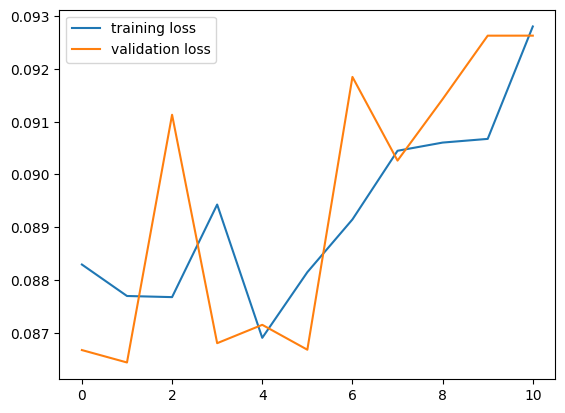

In [61]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

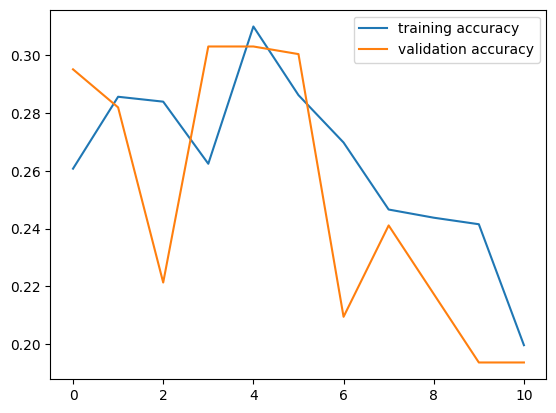

In [62]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

In [16]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [17]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

NameError: name 'confusion_matrix' is not defined

In [ ]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))

In [ ]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))

In [ ]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

In [ ]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels_t),
            yticklabels=np.unique(all_labels_t))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))

In [ ]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))